#Análise de sentimentos em tweets sobre o tópico CORONAVIRUS

Repositório: 

Script criado pelo Laboratório de inteligência Artificial da PUC-Rio.

Assunto: Análise de sentinetos em tweets em inglês sobre o tópico 'coronavirus', para ser apresentado na série de palestras sobre como a Inteligência Artificial é capaz de ajudar neste momento de pandemia, do curso de pós graduação BIMASTER (https://bit.ly/ia-puc-rio).

Palestras gravadas podem ser encontradas no link http://www.iacontracovid.com.br/palestras/

Aplicações desenvolvidas pelo laboratório podem ser testadas e avaliadas no link http://www.iacontracovid.com.br

*Tweets carregados aqui foram extraídos pelo script 'Tweets_Covid-19.ipynb'




##Mapear o drive para carregar base de tweets

In [16]:
import pandas as pd
tweets = pd.read_csv('tweetspt.csv', engine='python') # tweets_coronavirus_brazil_spain_usa_100
tweets.head()

,Unnamed: 0,date,tweet,username,retweet,nlikes,nreplies,nretweets,near
0,0,2020-05-31 23:33:26,qual o melhor filme de harry potter e por que ...,thasspetacular,False,1,0,0,Brazil
1,1,2020-05-31 23:20:25,Mais uma encomenda pronta!!\nMamãe Magali está...,SimoneBoff,False,0,0,0,Brazil
2,2,2020-05-31 23:17:45,"6 horas pra fazer mais 10 times no Brasfoot, a...",Eriblocked,False,0,0,0,Brazil
3,3,2020-05-31 22:32:40,Moro numa cidade que tem mil fábricas de pijam...,ItsPauloBitch,False,0,0,0,Brazil
4,4,2020-05-31 22:15:15,"Ai carai, como eu odeio essa parte de Harry Po...",lucasa_costa,False,0,0,0,Brazil


In [17]:
tweets = tweets.drop('Unnamed: 0', axis=1)
tweets.head()

,date,tweet,username,retweet,nlikes,nreplies,nretweets,near
0,2020-05-31 23:33:26,qual o melhor filme de harry potter e por que ...,thasspetacular,False,1,0,0,Brazil
1,2020-05-31 23:20:25,Mais uma encomenda pronta!!\nMamãe Magali está...,SimoneBoff,False,0,0,0,Brazil
2,2020-05-31 23:17:45,"6 horas pra fazer mais 10 times no Brasfoot, a...",Eriblocked,False,0,0,0,Brazil
3,2020-05-31 22:32:40,Moro numa cidade que tem mil fábricas de pijam...,ItsPauloBitch,False,0,0,0,Brazil
4,2020-05-31 22:15:15,"Ai carai, como eu odeio essa parte de Harry Po...",lucasa_costa,False,0,0,0,Brazil


In [18]:
tweets.shape

(4686, 8)

In [19]:
tweets['word_count'] = tweets['tweet'].apply(lambda x: len(str(x).split()))
tweets.head()

,date,tweet,username,retweet,nlikes,nreplies,nretweets,near,word_count
0,2020-05-31 23:33:26,qual o melhor filme de harry potter e por que ...,thasspetacular,False,1,0,0,Brazil,14
1,2020-05-31 23:20:25,Mais uma encomenda pronta!!\nMamãe Magali está...,SimoneBoff,False,0,0,0,Brazil,30
2,2020-05-31 23:17:45,"6 horas pra fazer mais 10 times no Brasfoot, a...",Eriblocked,False,0,0,0,Brazil,32
3,2020-05-31 22:32:40,Moro numa cidade que tem mil fábricas de pijam...,ItsPauloBitch,False,0,0,0,Brazil,20
4,2020-05-31 22:15:15,"Ai carai, como eu odeio essa parte de Harry Po...",lucasa_costa,False,0,0,0,Brazil,16


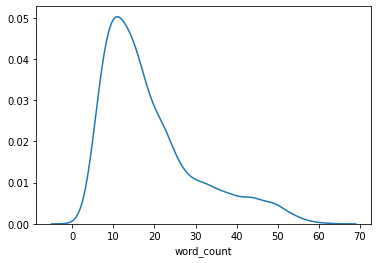

In [20]:
# distribuição da quantidade de palavras nos tweets
import seaborn as sns
sns.distplot(tweets.word_count, hist=False);

In [21]:
tweets = tweets[tweets.word_count > 5]
tweets.shape

(4559, 9)

In [22]:
tweets.near.value_counts()

Brazil    4559
Name: near, dtype: int64

###Base carregada e ajustada. Agora podemos seguir para o pré processamento!

#Pré-processamento do texto


In [23]:
import nltk
import spacy
!python -m spacy download en_core_web_md
!python -m spacy link en_core_web_md en --force
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
!pip install contractions
from contractions import contractions_dict
import unicodedata

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_md -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [26]:
# Carrega tokenizador e lista de stopwords
nlp = spacy.load('en')
tokenizer = ToktokTokenizer()
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('portuguese')
#stopword_list.remove('no')
#stopword_list.remove('not')
#stopword_list.append('coronaviru')
#stopword_list.append('pic.twitter.com')
#stopword_list.append('pic')
#stopword_list.append('twitter')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
stopword_list[0:40] # Ver as 5 primeiras stopwords (serão removidas)

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela']

In [28]:
# Código baseado no disponível em:
# https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch07_Analyzing_Movie_Reviews_Sentiment/text_normalizer.py
# Algumas alterações foram feitas

'''Remove stopwords'''
def remove_stopwords(text):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

'''Lematização
O objetivo da lematização e do stemming (função seguinte) é reduzir (deflexionar) uma palavra a sua base.

A diferença entre os dois é que o stemming corta a palavra tentando acertar a sua base na maioria da vezes,
enquanto a lematização reduz a base utilizando um vocabulário e a análise morfológica das palavras.

Exemplos:
1. A palavra "walk" é a base para "walking", e é corretamente reduzida pelo stemming e pela lematização.
2. A palavra "better" tem "good" como base (ou lema). Esse link é perdido pelo stemming.
3. A palavra "meeting" pode ser reduzido para um substantivo ou um verbo dependendo do contexto. 
   E.g., "in our last meeting" ou "We are meeting again tomorrow". 
   A lematização consegue fazer a redução de forma correta.

Deve-se escolher um ou outro. A desvantagem da lematização é que ela é mais custosa do ponto de vista computacional.
'''
def lemmatize(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

'''Stemming'''
def stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

'''Remove caracteres especiais'''
def remove_special_characters(text, remove_digits=False):
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)

  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

'''
Expandir contrações (muito presente na língua inglesa)
you've -> you have
he's -> he is
'''
def expand_contractions(text, contraction_mapping=contractions_dict):
  contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                    flags=re.IGNORECASE | re.DOTALL)

  def expand_match(contraction):
      match = contraction.group(0)
      first_char = match[0]
      expanded_contraction = contraction_mapping.get(match) \
          if contraction_mapping.get(match) \
          else contraction_mapping.get(match.lower())
      expanded_contraction = first_char + expanded_contraction[1:]
      return expanded_contraction
  
  #pequena mudança aqui
  try:
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
  except:
    return text
  return expanded_text

'''Remove acentos'''
def remove_accent(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

'''Remove links'''
def strip_html_tags(text):
  text = re.sub(r"http[s]?://\S+", "", text)
  text = re.sub(r"\s+", " ", text)
  soup = BeautifulSoup(text, "html.parser")
  stripped_text = soup.get_text()
  return stripped_text

In [29]:
#Funções para limpar texto: chama todas as funções declaradas acima e faz mais alguns pré processamentos
def clean(corpus):

  normalized_corpus = []
  for doc in corpus:
    # remove links
    doc = strip_html_tags(doc)

    # remove acentuação
    doc = remove_accent(doc)

    # expandir contrações
    doc = expand_contractions(doc)
    # doc = list(cont.expand_texts(doc, precise=True))

    # coloca tudo em caixa baixa
    doc = doc.lower()

    # remove linhas em branco
    doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)

    # lemmatização
    doc = lemmatize(doc)

    # remove caracteres especiais 
    doc = remove_special_characters(doc)

    # remove linhas em branco
    doc = re.sub(' +', ' ', doc)

    # remove stopwords
    doc = remove_stopwords(doc)

    # insere na lista o texto após limpeza
    normalized_corpus.append(doc)

  return normalized_corpus # retorna corpus pré processado

In [30]:
# Vamos testar a limpeza de dados
c = ["Tim's walking along with his brother \n empty line",
     "UPPER CASE",
     "doctors and nurses #corona",
     "in our last meeting", 
     "We are meeting again tomorrow" , 
     "It's better to talk straight",
     "Renée Zellweger @renee",
     "I'd like to try"]
clean(c)

['tims walk along with his brother empty line',
 'upper case',
 'doctor and nurses corona',
 'in our last meeting',
 'we be meet again tomorrow',
 'it be well to talk straight',
 'renee zellweger renee',
 'i would like to try']

In [31]:
# Agora vamos aplicar a limpeza a nossa base de dados!
import time

start = time.time()
normalized_corpus = clean(tweets.tweet.to_list())
normalized_corpus[0:5]

end = time.time()

In [32]:
total_time = (end - start)/60 # em minutos
print("Tempo de limpeza dos dados")
print(str(total_time) + " minutos")

Tempo de limpeza dos dados
0.9562031030654907 minutos


In [33]:
# E substituir na base de dados de tweets
tweets.tweet = normalized_corpus
tweets.head()

,date,tweet,username,retweet,nlikes,nreplies,nretweets,near,word_count
0,2020-05-31 23:33:26,melhor filme harry potter prisioneiro azkaban,thasspetacular,False,1,0,0,Brazil,14
1,2020-05-31 23:20:25,encomenda pronta mamae magali arrasando cachec...,SimoneBoff,False,0,0,0,Brazil,30
2,2020-05-31 23:17:45,6 horas pra fazer 10 time brasfoot todo ja 30 ...,Eriblocked,False,0,0,0,Brazil,32
3,2020-05-31 22:32:40,moro cidade mil fabricas pijama nao existe pij...,ItsPauloBitch,False,0,0,0,Brazil,20
4,2020-05-31 22:15:15,ai carai odeio parte harry potter aranhas agon...,lucasa_costa,False,0,0,0,Brazil,16


Agora já temos nossa base limpa e podemos seguir para análise de sentimentos!

#Análise de Sentimentos


## Vamos primeiro gerar uma wordcloud!

In [36]:
# https://amueller.github.io/word_cloud/auto_examples/masked.html#sphx-glr-download-auto-examples-masked-py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud

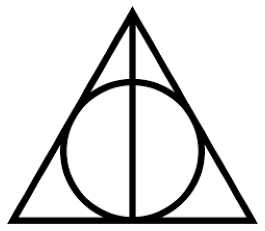

In [37]:
# Shape tirado do site FlatIcon (https://www.flaticon.com/free-icon/coronavirus_2869116)
corona_mask = np.array(Image.open("hp1.png"))

img=mpimg.imread('hp1.png')
imgplot = plt.imshow(img)
plt.axis("off");

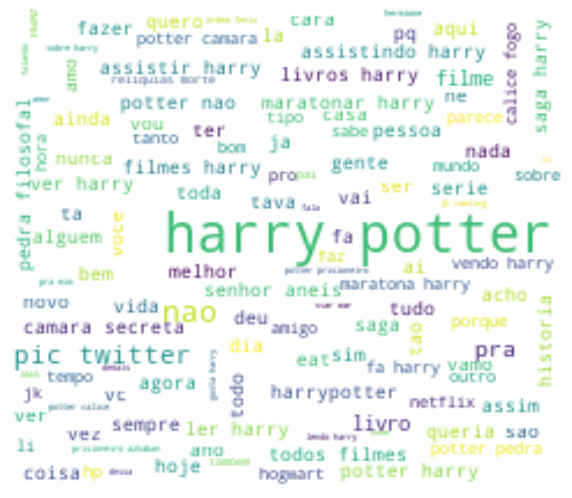

In [38]:
# define o shape e as características da nuvem de palavras
wc = WordCloud(background_color="white", max_words=2000, mask=corona_mask,
               contour_width=1, contour_color='steelblue')

# inclui as palavras na nuvem
tweets_texts = ' '.join(tweets.tweet) # converte lista de textos em um único texto
wc.generate(tweets_texts)

# mostra a nuvem de palavras
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='bilinear'); 
plt.axis("off");

##Agora vamos testar as bibliotecas para análises de sentimentos!


In [39]:
# Bibliotecas para análise de sentimentos

# https://pypi.org/project/afinn/
!pip install Afinn
from afinn import Afinn

# https://www.nltk.org/
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for Afinn: filename=afinn-0.1-cp36-none-any.whl size=53452 sha256=5c4b61db92a9d8774e4db2a099f97e798fa923a54b4a0ff5e6b912c26d58d5f9
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built Afinn
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [40]:
# Pegamos uma frase qualquer
cleaned_text = clean(["valdemor é muito ruim"])
print(cleaned_text)

# E vamos testar a análise usando a biblioteca AFINN
afinn = Afinn()
sentiment_score = afinn.score(cleaned_text[0]) 
print(sentiment_score)

['valdemor ruim']
0.0


In [ ]:
# Vamos testar a biblioteca NLTK
sid = SentimentIntensityAnalyzer()
analysis_score = sid.polarity_scores(cleaned_text[0])
analysis_score

{'compound': -0.8297, 'neg': 0.721, 'neu': 0.279, 'pos': 0.0}

In [ ]:
analysis_score.get('compound') # resultado composto de quão negativa, quão neutra e quão positiva é a frase

-0.8297

In [ ]:
# Vamos agora aplicar a nossa base de dados!

#percorro todos os tweets avaliando o sentimento
sentiment_afinn = []
sentiment_afinn_class = []
sentiment_nltk = []
sentiment_nltk_class = []

for tweet in tweets.tweet:
  afinn_score = afinn.score(tweet)
  sentiment_afinn.append(afinn_score)
  sentiment_afinn_class.append('positive' if afinn_score>0 else 'neutral' if afinn_score == 0 else 'negative')

  nltk_score = sid.polarity_scores(tweet).get('compound')
  sentiment_nltk.append(nltk_score)
  sentiment_nltk_class.append('positive' if nltk_score>0 else 'neutral' if nltk_score == 0 else 'negative')

# Salvo no dataframe
tweets['SentimentAFINN'] = sentiment_afinn 
tweets['SentimentAFINN_class'] = sentiment_afinn_class 
tweets['SentimentNLTK'] = sentiment_nltk 
tweets['SentimentNLTK_class'] = sentiment_nltk_class 

In [ ]:
tweets.head()

,date,tweet,username,retweet,nlikes,nreplies,nretweets,near,word_count,SentimentAFINN,SentimentAFINN_class,SentimentNLTK,SentimentNLTK_class
0,2020-05-31 23:44:06,yeah hubby make first 3 harry potter movie not...,Felinefemale,False,1,1,0,United States,38,2.0,positive,0.2448,positive
3,2020-05-31 22:54:15,top 4 book amazon harry potter 5th hunger game...,NathanWurtzel,False,0,1,0,United States,15,0.0,neutral,0.1280,positive
4,2020-05-31 22:49:47,new daily exercise routine inspire listen harr...,CristaGalli22,False,0,0,0,United States,44,4.0,positive,0.5719,positive
6,2020-05-31 22:25:54,dear harry potter fan truth must accept day no...,drmav,False,0,0,0,United States,51,7.0,positive,0.8748,positive
8,2020-05-31 22:09:45,today day start harry potter book beginning,oheysj,False,3,0,0,United States,14,0.0,neutral,0.0000,neutral


In [ ]:
# Tirar hora da data para conseguir agrupar os dados
import re
pattern = ' [0-2][0-9]:[0-5][0-9]' # :[0-5][0-9]  ==> incluir mais essa parte se a hora estiver no formato hh:mm:ss
timestamps = []
for timestamp in tweets.date:
  timestamps.append(re.sub(pattern, '', timestamp))

tweets.date = timestamps
tweets.head()

,date,tweet,username,retweet,nlikes,nreplies,nretweets,near,word_count,SentimentAFINN,SentimentAFINN_class,SentimentNLTK,SentimentNLTK_class
0,2020-05-31:06,yeah hubby make first 3 harry potter movie not...,Felinefemale,False,1,1,0,United States,38,2.0,positive,0.2448,positive
3,2020-05-31:15,top 4 book amazon harry potter 5th hunger game...,NathanWurtzel,False,0,1,0,United States,15,0.0,neutral,0.1280,positive
4,2020-05-31:47,new daily exercise routine inspire listen harr...,CristaGalli22,False,0,0,0,United States,44,4.0,positive,0.5719,positive
6,2020-05-31:54,dear harry potter fan truth must accept day no...,drmav,False,0,0,0,United States,51,7.0,positive,0.8748,positive
8,2020-05-31:45,today day start harry potter book beginning,oheysj,False,3,0,0,United States,14,0.0,neutral,0.0000,neutral


In [ ]:
# calcular a média dos sentimetos para toda a base
mean_sentiments = tweets.groupby('date').mean()
mean_sentiments.head()

,retweet,nlikes,nreplies,nretweets,word_count,SentimentAFINN,SentimentNLTK
date,,,,,,,
2020-05-31:00,False,1.0,0.0,0.5,21.0,0.0,0.0000
2020-05-31:01,False,2.0,0.0,0.5,19.0,2.5,0.4474
2020-05-31:03,False,1.0,0.0,0.0,26.5,1.5,0.2680
2020-05-31:04,False,4.0,1.0,0.0,34.0,-7.0,-0.9042
2020-05-31:06,False,1.0,1.0,0.0,38.0,2.0,0.2448


###AFINN

Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)
Paper with supplement: http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6006/pdf/imm6006.pdf

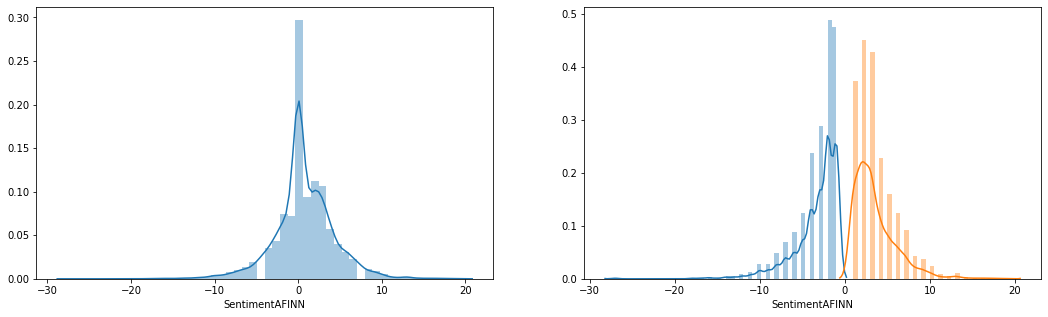

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(18,5))
sns.distplot(tweets.SentimentAFINN, label = 'polarity', ax=axs[0]);

negative_tweets = tweets[tweets.SentimentAFINN_class == 'negative']
positive_tweets = tweets[tweets.SentimentAFINN_class == 'positive']
neutral_tweets = tweets[tweets.SentimentAFINN_class == 'neutral']
sns.distplot(negative_tweets.SentimentAFINN, label = 'negative');
sns.distplot(positive_tweets.SentimentAFINN, label = 'positive');

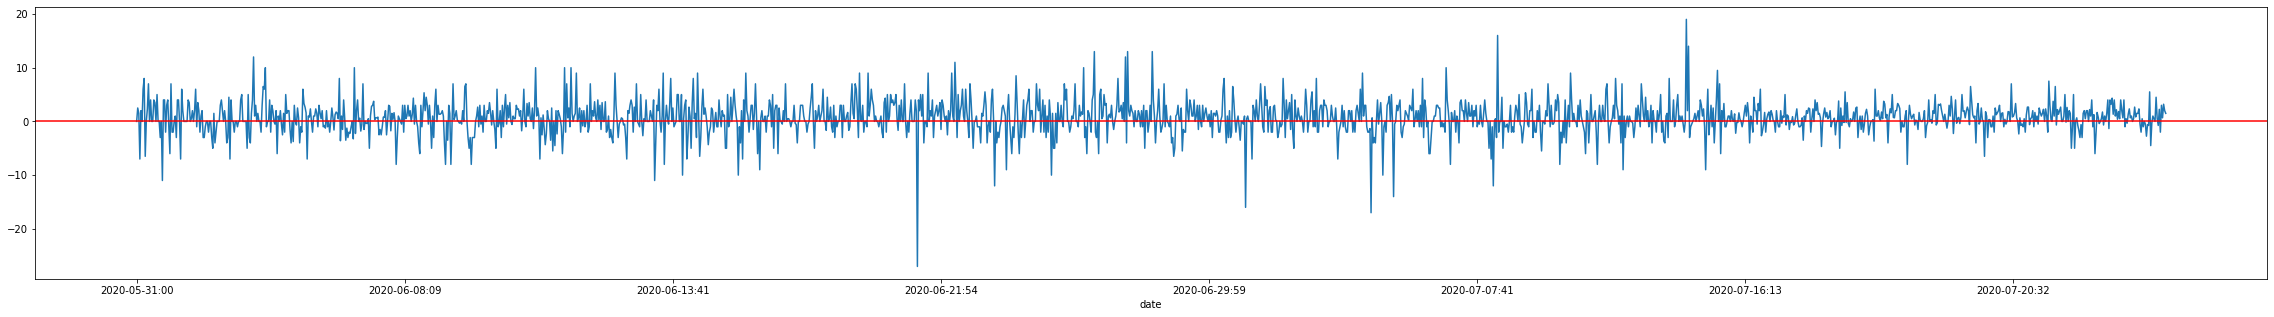

In [ ]:
chart = mean_sentiments.SentimentAFINN.plot(figsize=(40,5)); # se quiser aumentar o tamanho do gráfico, passar como parâmetro: figsize=(10,5)
plt.axhline(y=0, color='r', linestyle='-');
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

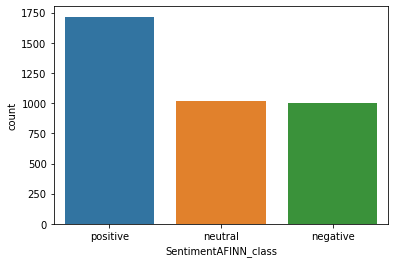

In [ ]:
sns.countplot(x='SentimentAFINN_class', data=tweets);

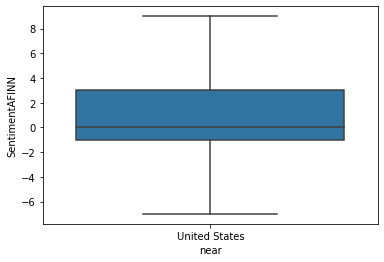

In [ ]:
# boxplot da polaridade por cidade
sns.boxplot(x='near', y='SentimentAFINN', data=tweets, showfliers = False);
# sns.swarmplot(x='near', y='SentimentAFINN', data=tweets, color="gray", size=3);

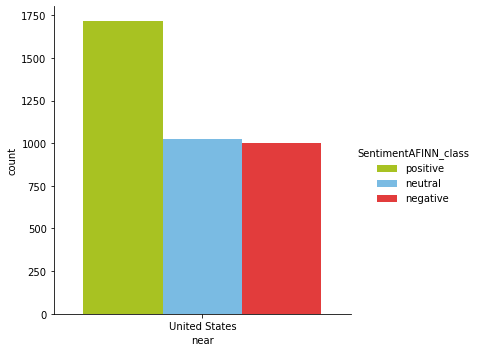

In [ ]:
sns.catplot(x="near", hue="SentimentAFINN_class", data=tweets, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"});

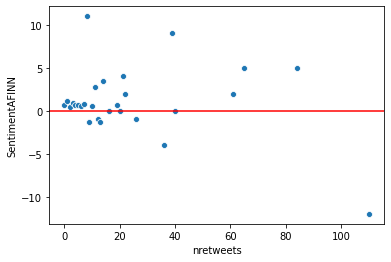

In [ ]:
mean_by_nretweets = tweets.groupby('nretweets').mean()
mean_by_nretweets=mean_by_nretweets[0:234] # retirar os últimos 3 que são muito extremos

# fig, axs = plt.subplots())
sns.scatterplot(x=mean_by_nretweets.index, y="SentimentAFINN", data=mean_by_nretweets)
plt.axhline(y=0, color='r', linestyle='-');

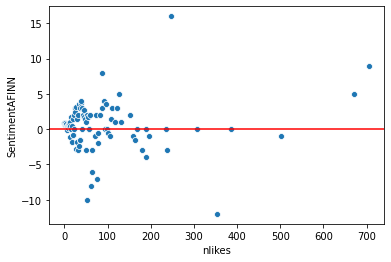

In [ ]:
mean_by_nlikes = tweets.groupby('nlikes').mean()
mean_by_nlikes=mean_by_nlikes[0:234] # retirar os últimos 3 que são muito extremos
sns.scatterplot(x=mean_by_nlikes.index, y="SentimentAFINN", data=mean_by_nlikes)
plt.axhline(y=0, color='r', linestyle='-');

###NLTK

Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.

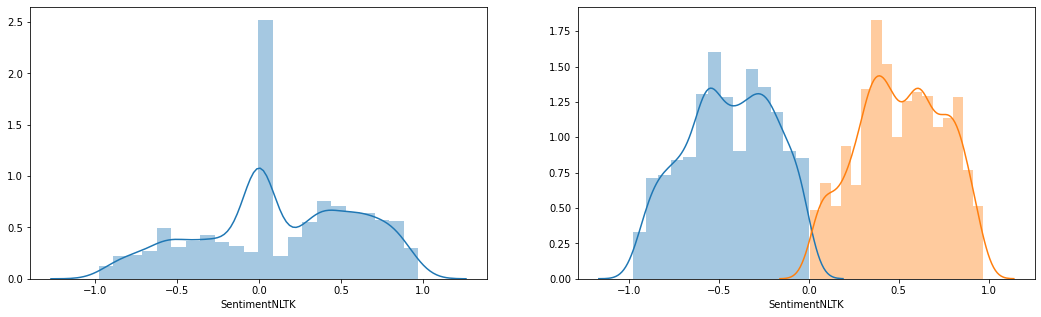

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(18,5))
sns.distplot(tweets.SentimentNLTK, label = 'polarity', ax=axs[0]);

negative_tweets = tweets[tweets.SentimentNLTK_class == 'negative']
positive_tweets = tweets[tweets.SentimentNLTK_class == 'positive']
sns.distplot(negative_tweets.SentimentNLTK, label = 'negative');
sns.distplot(positive_tweets.SentimentNLTK, label = 'positive');

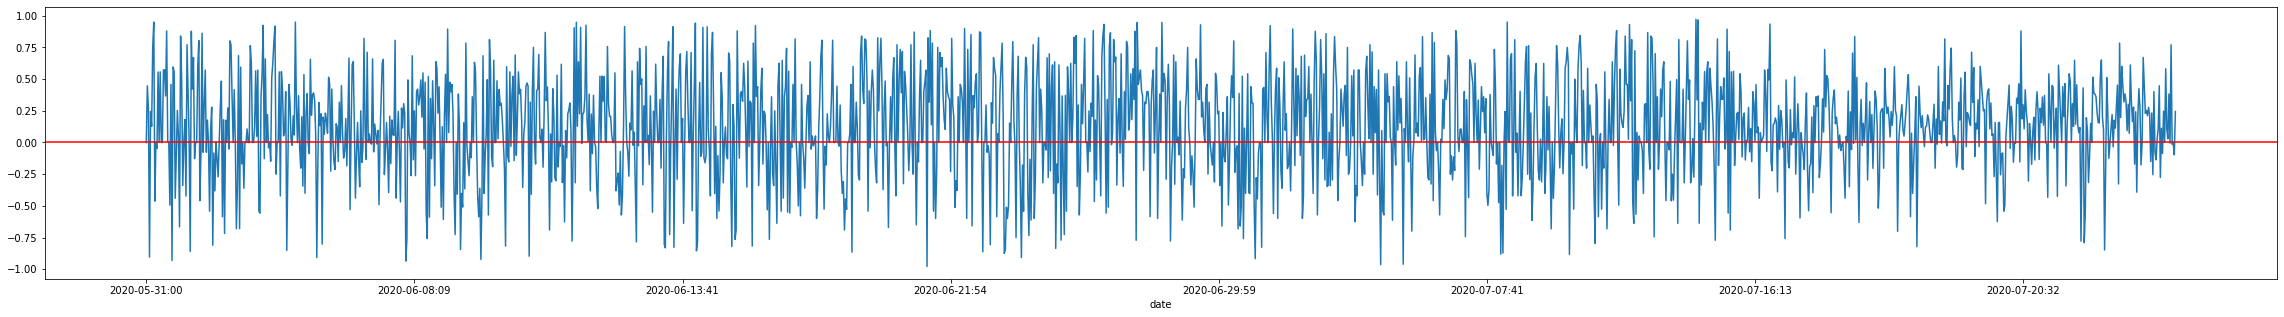

In [ ]:
mean_sentiments.SentimentNLTK.plot(figsize=(40,5));
plt.axhline(y=0, color='r', linestyle='-');

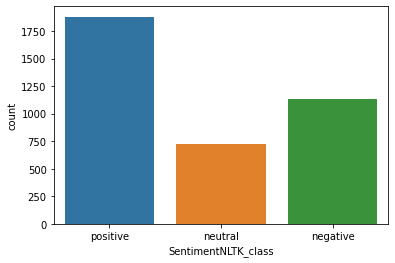

In [ ]:
sns.countplot(x='SentimentNLTK_class', data=tweets);

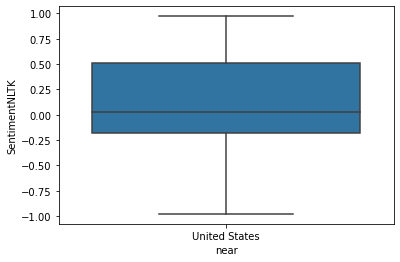

In [ ]:
# boxplot da polaridade por cidade
sns.boxplot(x='near', y='SentimentNLTK', data=tweets, showfliers = False);

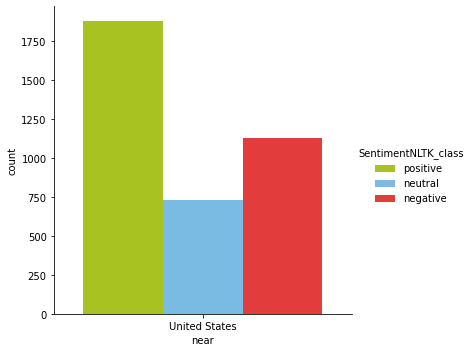

In [ ]:
sns.catplot(x="near", hue="SentimentNLTK_class", data=tweets, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"});

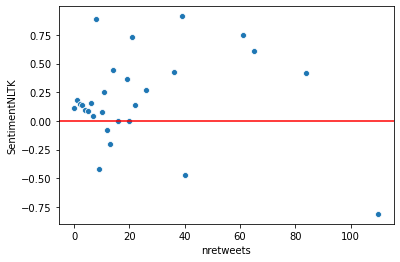

In [ ]:
mean_by_nretweets = tweets.groupby('nretweets').mean()
mean_by_nretweets=mean_by_nretweets[0:234] # retirar os últimos 3 que são muito extremos

# fig, axs = plt.subplots())
sns.scatterplot(x=mean_by_nretweets.index, y="SentimentNLTK", data=mean_by_nretweets)
plt.axhline(y=0, color='r', linestyle='-');

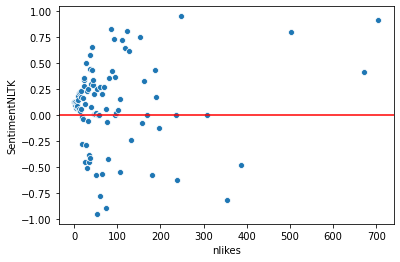

In [ ]:
mean_by_nlikes = tweets.groupby('nlikes').mean()
mean_by_nlikes=mean_by_nlikes[0:234] # retirar os últimos 3 que são muito extremos
sns.scatterplot(x=mean_by_nlikes.index, y="SentimentNLTK", data=mean_by_nlikes)
plt.axhline(y=0, color='r', linestyle='-');

# Melhorias que poderiam ser feitas



1.   Limpar tweets que contenham poucas palavras;
2.   Buscar tweets no mundo inteiro;
3.   Avaliar emoções de raiva, de tristeza, felicidade, etc, além das categorias 'positivo', 'neutro' e 'negativo' explorados neste trabalho;
4.   Criar wordcloud por país, por classificação de sentimento e por país E classificação de sentimento.
5.   Utilizar modelos de machine learning para análise de sentimentos.
6.   Analisar a filtragem de retweets.
7.   Filtrar teets de bots (machine learning).
8. Analisar palavras repetidas na wordcloud.


